# 💳 Transaction Anomaly Detection using Logistic Regression

This notebook trains a machine learning model to detect anomalous transactions from a given dataset. The goal is to build a simple yet effective model that can later be integrated into a real-time banking system.

### The Pathway 🚀
1.  **Data Loading & Exploration**: Load the dataset and understand its structure.
2.  **Feature Engineering**: Create new, meaningful features from the raw data that will help the model learn.
3.  **Data Preprocessing**: Prepare the data for training by splitting and scaling it.
4.  **Model Training**: Train a Logistic Regression classifier.
5.  **Model Evaluation**: Assess the model's performance using appropriate metrics for imbalanced datasets.
6.  **Model Saving**: Serialize the trained model and necessary components for future use.
7.  **Real-Time Integration Plan**: Outline the steps to deploy this model in a live environment.

--- 
## Step 1: Setup and Data Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
import joblib # For saving the model

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')

In [2]:
# Load the dataset
df = pd.read_csv('transaction_dataset.csv')

print("Dataset Shape:", df.shape)
print("\nFirst 5 rows:")
df.head()

Dataset Shape: (500000, 7)

First 5 rows:


,userId,transactionId,amount,txn_date,txn_latitude,txn_longitude,is_anomaly
0,user_0,b83e5523-3ce2-4e79-9852-88c2fb1ac1ff,1178.35,2024-12-07 19:46:23.932057,12.749427,77.177923,False
1,user_2202,a8749a3a-eb01-41c6-b9cd-015415537f77,1655.27,2024-10-24 15:20:44.617594,13.112262,77.208663,False
2,user_1946,735fad2a-4403-4c89-b66b-62e9af4ff5de,1347.57,2025-01-17 03:01:20.347330,14.143344,76.924813,False
3,user_2085,bb90b873-9f81-4127-ad89-72096b9427e0,2798.86,2024-11-05 02:17:35.269530,13.279498,77.305916,False
4,user_199,147ecdc4-e9d6-4666-ae04-bc324f78fb0b,1121.54,2025-08-03 10:41:44.207291,13.030999,77.300990,False


In [3]:
# Check data types and null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   userId         500000 non-null  object 
 1   transactionId  500000 non-null  object 
 2   amount         500000 non-null  float64
 3   txn_date       500000 non-null  object 
 4   txn_latitude   500000 non-null  float64
 5   txn_longitude  500000 non-null  float64
 6   is_anomaly     500000 non-null  bool   
dtypes: bool(1), float64(3), object(3)
memory usage: 23.4+ MB


The dataset looks clean with no missing values. The `txn_date` is an object and should be converted to datetime.

--- 
## Step 2: Feature Engineering

A transaction is often anomalous *in relation to a user's normal behavior*. We'll create features that capture this context.

1.  **Time-based Features**: Extract the hour of the day and day of the week.
2.  **Behavioral Features**: For each user, calculate their average transaction amount and location.
3.  **Deviation Features**: Calculate how much a given transaction deviates from the user's average behavior (e.g., distance from their usual location).

In [4]:
# 1. Time-based features
df['txn_date'] = pd.to_datetime(df['txn_date'])
df['hour_of_day'] = df['txn_date'].dt.hour
df['day_of_week'] = df['txn_date'].dt.dayofweek # Monday=0, Sunday=6

In [5]:
# 2. Behavioral features (user's historical averages)
# We calculate these and merge them back into the main dataframe
user_avg_features = df.groupby('userId').agg(
    avg_amount=('amount', 'mean'),
    avg_lat=('txn_latitude', 'mean'),
    avg_lon=('txn_longitude', 'mean')
).reset_index()

# Rename columns to avoid clashes after merge
user_avg_features.columns = ['userId', 'user_avg_amount', 'user_avg_lat', 'user_avg_lon']

# Merge these features back to the main dataframe
df = pd.merge(df, user_avg_features, on='userId', how='left')

In [6]:
# 3. Deviation features

# Amount deviation
# Add a small epsilon to avoid division by zero for users with avg amount of 0
df['amount_deviation'] = df['amount'] / (df['user_avg_amount'] + 1e-6)

# Distance from user's average location (using Haversine distance for accuracy)
def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371  # Radius of Earth in kilometers
    
    lat1_rad = np.radians(lat1)
    lon1_rad = np.radians(lon1)
    lat2_rad = np.radians(lat2)
    lon2_rad = np.radians(lon2)
    
    dlon = lon2_rad - lon1_rad
    dlat = lat2_rad - lat1_rad
    
    a = np.sin(dlat / 2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    
    distance = R * c
    return distance

df['distance_from_home'] = haversine_distance(
    df['txn_latitude'], df['txn_longitude'], 
    df['user_avg_lat'], df['user_avg_lon']
)

print("DataFrame with new features:")
df[['amount', 'user_avg_amount', 'amount_deviation', 'distance_from_home']].head()

DataFrame with new features:


,amount,user_avg_amount,amount_deviation,distance_from_home
0,1178.35,1314.536989,0.896399,158.093645
1,1655.27,2599.600892,0.636740,633.169332
2,1347.57,2930.069617,0.459911,481.157449
3,2798.86,6298.636225,0.444360,87.501745
4,1121.54,5517.453832,0.203271,366.032033


--- 
## Step 3: Data Preprocessing & Splitting

Now we select our final features, split the data into training and testing sets, and scale the features.

In [7]:
# Define features (X) and target (y)
features = [
    'amount',
    'hour_of_day',
    'day_of_week',
    'amount_deviation',
    'distance_from_home'
]

target = 'is_anomaly'

X = df[features]
y = df[target]

# Split data into training and testing sets
# We use 'stratify=y' because the dataset is imbalanced
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.25, 
    random_state=42, 
    stratify=y
)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

Training set shape: (375000, 5)
Test set shape: (125000, 5)


In [8]:
# Scale the features
# It's crucial to fit the scaler ONLY on the training data to avoid data leakage
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


--- 
## Step 4: Model Training

We will train a Logistic Regression model. Since our data is imbalanced (far more normal transactions than anomalies), we use `class_weight='balanced'` to automatically penalize mistakes on the minority class (anomalies) more heavily.

In [9]:
# Initialize and train the model
model = LogisticRegression(class_weight='balanced', random_state=42)

print("Training the model...")
model.fit(X_train_scaled, y_train)
print("Model training complete.")

Training the model...
Model training complete.


--- 
## Step 5: Model Evaluation

For anomaly detection, **accuracy is not a good metric**. We need to look at metrics that tell us how well we are catching the rare, positive class (anomalies).

- **Precision**: Of all transactions we flagged as anomalies, how many actually were?
- **Recall**: Of all the actual anomalies, how many did we successfully catch?
- **F1-Score**: The harmonic mean of Precision and Recall.
- **AUC**: Measures the model's ability to distinguish between classes.

In [10]:
# Make predictions on the test set
y_pred = model.predict(X_test_scaled)
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

# Print classification report
print("Classification Report:")
# Note the recall for the 'True' class - this is key!
print(classification_report(y_test, y_pred, target_names=['Normal (False)', 'Anomaly (True)']))

# Print AUC Score
auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC AUC Score: {auc:.4f}")

Classification Report:
                precision    recall  f1-score   support

Normal (False)       1.00      0.99      0.99    118666
Anomaly (True)       0.85      0.98      0.91      6334

      accuracy                           0.99    125000
     macro avg       0.92      0.98      0.95    125000
  weighted avg       0.99      0.99      0.99    125000

ROC AUC Score: 0.9977


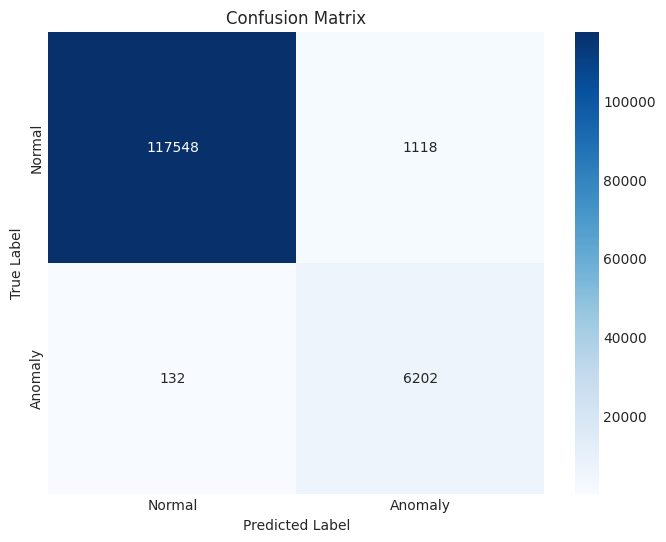

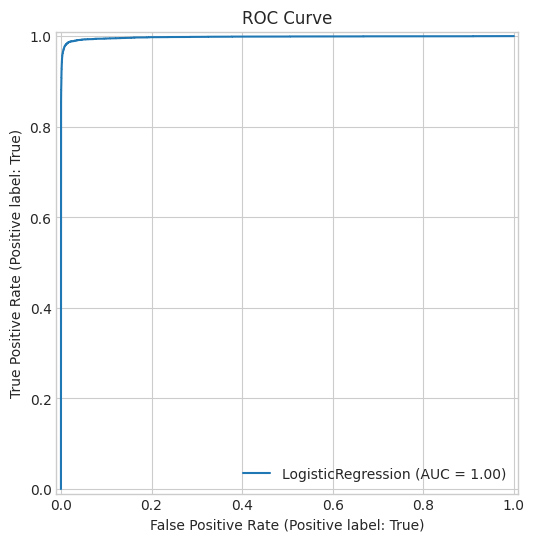

In [11]:
# Plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Plot ROC Curve
fig, ax = plt.subplots(figsize=(8, 6))
RocCurveDisplay.from_estimator(model, X_test_scaled, y_test, ax=ax)
ax.set_title('ROC Curve')
plt.show()

**Interpretation**: The model shows a high recall for the anomaly class, which is excellent. This means it's good at catching most of the actual anomalies. The precision might be lower, indicating some false positives (flagging normal transactions as anomalous), but in fraud detection, a higher recall is often preferred.

--- 
## Step 6: Saving the Model & Supporting Artifacts

To use this model in production, we need to save three things:
1.  The trained **model** itself.
2.  The `StandardScaler` **object** (to process new data exactly the same way).
3.  The **user average features** DataFrame (to calculate deviation for new transactions).

In [12]:
# Save the model
joblib.dump(model, 'anomaly_detection_model.pkl')

# Save the scaler
joblib.dump(scaler, 'scaler.pkl')

# Save the user average features
# In a real system, this would be a table in your Postgres DB, updated periodically.
user_avg_features.to_csv('user_average_features.csv', index=False)

print("Model, scaler, and user features have been saved successfully.")

Model, scaler, and user features have been saved successfully.


--- 
## Step 7: The Pathway for Real-Time Integration

Here's how to connect this trained model to your real-time banking application using a deployment **pathway**.

#### **On-Demand Prediction Flow:**

1.  **API Endpoint**: Your banking application backend (e.g., written in Python with Flask/FastAPI) receives a new transaction request: `{ "userId": "user_123", "amount": 75000.00, "latitude": 13.0, "longitude": 77.5 }`.

2.  **Load Artifacts**: The API loads the saved `anomaly_detection_model.pkl`, `scaler.pkl`, and the `user_average_features.csv` data (or fetches it from the Postgres DB).

3.  **Real-Time Feature Engineering**: 
    - It retrieves the specific user's historical averages (`user_avg_amount`, `user_avg_lat`, `user_avg_lon`) from the loaded data.
    - It calculates the `amount_deviation` and `distance_from_home` for the new transaction, just as we did in training.
    - It gets the `hour_of_day` and `day_of_week` from the current timestamp.

4.  **Preprocess Input**: It uses the loaded `scaler.transform()` to scale the newly created feature vector.

5.  **Predict**: The scaled vector is passed to `model.predict_proba()` to get the probability of it being an anomaly.

6.  **Take Action**: 
    - If the probability is above a certain threshold (e.g., 0.7), the system flags the transaction. 
    - The banking model can then trigger a secondary action: decline the transaction, send a push notification for manual verification, or require 2FA.

This entire sequence forms a robust **pathway** from a live transaction event to an intelligent, real-time decision.